### Based on the paper from Goodwill et al.

In [1]:
import math
import os
import h5py

import numpy as np
import pandas as pd
import seaborn as sns
from numpy.testing import assert_almost_equal
from scipy import stats
from tqdm import tqdm
from tools.cache import get_loc, cache_np
from tools.plotter import shadow_plot

from tools.traceloader import ASCAD, TraceCategory

sns.set_style("whitegrid")

trace_len = 50
sample_size = 350

def gen_trace(key=0, mu=128):
    return np.array([np.random.normal(mu + (key/256 - 1), 1, trace_len) for _ in range(sample_size)], dtype=np.uint8)

def gen_mask_trace(mu=128):
    random_keys = np.random.uniform(0, 256, sample_size) / 256

    return np.array([np.random.normal(mu + (rk - 1), 1, trace_len) for rk in random_keys], dtype=np.uint8)

tg_a1 = gen_trace(0)
tg_a2 = gen_trace(256)
tg_b = gen_mask_trace()

gen_mask_trace()

array([[126, 127, 126, ..., 126, 127, 127],
       [128, 127, 127, ..., 128, 127, 127],
       [128, 128, 127, ..., 128, 126, 126],
       ...,
       [127, 128, 126, ..., 128, 127, 129],
       [127, 129, 127, ..., 127, 126, 127],
       [126, 128, 126, ..., 126, 126, 127]], dtype=uint8)

In [2]:
def confidence_level(all_t_values, p=.95):
    tvs_flat = abs(all_t_values.flatten())
    n = round(len(tvs_flat) * p)

    return sorted(tvs_flat)[n]

def device_fails(ta: np.array, tb: np.array, c=2.5):
    """
    @param ta should be a positive-valued array of t-test results from some power trace with given key.
    @param tb should be a positive-valued array of t-test results from a different set of traces with the same key.
    @param c should be the confidence value.
    """
    return np.array((ta >= c) * (tb >= c)).any()

def t_test(a, b):
    num = a.mean(axis=0) - b.mean(axis=0)
    den = (((a.var(axis=0) / len(a)) + (b.var(axis=0) / len(b))) ** .5)

    return np.array(num / den)

def stats_t_test(a, b):
    return stats.ttest_ind(a, b, equal_var=False)[0]

def gen_rvs(mean=5):
    return lambda: np.array([stats.norm.rvs(loc=mean,scale=.1,size=50) for _ in range(50)])

def tvla(test, lefts, rights):
    a, b, c, d = lefts
    x, y = rights

    tk1 = abs(np.array(test(a, c)))
    tk2 = abs(np.array(test(b, d)))
    tm1 = abs(np.array(test(a, x)))
    tm2 = abs(np.array(test(b, y)))

    confidence = np.percentile(np.array([*tk1, *tk2, *tm1, *tm2]).flatten(), 95)

    return device_fails(tk1, tk2, confidence), device_fails(tm1, tm2, confidence)

def bench(test, gen_one, gen_two, total=100):
    acc = np.array([(False, False)] * total)
    for ix in tqdm(range(total)):
        acc[ix] = tvla(test, [gen_one() for _ in range(4)], (gen_two(), gen_two()))

    return np.array(acc).sum(axis=0)

In [3]:
# bench(t_test, gen_rvs(5), gen_rvs(6))

In [4]:
# bench(t_test, gen_trace, gen_mask_trace)

In [5]:
ascad = ASCAD()

In [6]:
def smote(trace_categories, target_size, dtype=np.uint8):
    def get_point(traces):
        t_shape = traces.shape
        x, y = 0, 0
        while x == y:
            x, y = np.random.randint(t_shape[0]), np.random.randint(t_shape[0])

        smoted_diff = (np.array(traces[y], dtype=int) - np.array(traces[x], dtype=int)) * np.random.uniform(size=t_shape[1])
        smoted_diff = np.array([np.array(t, dtype=dtype) for t in smoted_diff])

        return traces[x] + smoted_diff

    acc = []

    for c_ix, category in enumerate(trace_categories):
        res = np.zeros((len(category), target_size, category[0].shape[1]), dtype=dtype)

        for s_ix, trace_slice in enumerate(category):
            app = [get_point(trace_slice) for _ in range(target_size - len(trace_slice))]

            if len(app) > 0:
                res[s_ix] = np.concatenate((trace_slice, app))
            else:
                res[s_ix] = trace_slice

        acc.append(res)

    return acc

Generating contingency tables: 100%|██████████| 1/1 [00:00<00:00, 31.35it/s]


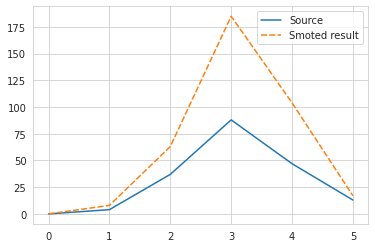

In [7]:
class CTableStore:
    def __init__(self, tc: TraceCategory, num_keys=256):
        self.tc = tc
        self.num_keys = num_keys
        self.size = max([math.ceil(len(self.tc.filter_traces(k)) / 2) for k in range(self.num_keys)])

        t_max = max([self.tc.filter_traces(k).max() for k in range(self.num_keys)]) + 128
        t_min = min([self.tc.filter_traces(k).min() for k in range(self.num_keys)]) + 128

        self.trace_type = np.uint8
        # Maximum value of trace should be lower than the capacity of uint8.
        assert t_min > 0
        assert t_max < np.iinfo(self.trace_type).max

        self.table_type = np.uint16
        # Maximum value of bincount should be lower than the capacity of uint16.
        assert self.size < np.iinfo(self.table_type).max

        self.slices = {}
        self.gen_slices()

        self.smoted = {}
        for k in tqdm(range(self.num_keys), "SMOTEing traces"):
            self.smoted[k] = np.array(smote(self.slices[k], self.size, self.trace_type))

        self.tables = {}
        self.gen_tables()

    def gen_slices(self):
        res = {}

        for k in tqdm(range(self.num_keys), "Slicing up traces"):
            ts = self.tc.filter_traces(k) + 128
            uts = np.array([np.array(t, dtype=self.trace_type) for t in ts])

            np.random.shuffle(uts)
            ts4 = np.array(np.array_split(uts.copy(), 4))
            np.random.shuffle(uts)
            ts2 = np.array(np.array_split(uts, 2))

            res[k] = np.array([ts4, ts2])

        self.slices = res

    def gen_tables(self):
        res = {}

        for k in tqdm(range(self.num_keys), "Generating contingency tables"):
            res[k] = {}
            for c, category in enumerate(self.smoted[k]):
                res[k][c] = {}
                for s, trace_slice in enumerate(category):
                    ts = np.moveaxis(trace_slice, 0, -1)
                    res[k][c][s] = np.array(
                        [np.array(np.bincount(t, minlength=256), dtype=self.table_type) for t in ts])

        self.tables = res

cts = CTableStore(ascad.masked.profile, 1)

test_cts_split = np.array([i[0] for i in cts.slices[0][0][0]])
test_cts_data = np.array([i[0] for i in cts.smoted[0][0][0]])

sns.lineplot(data=pd.DataFrame(zip(np.bincount(test_cts_split)[-6:], np.bincount(test_cts_data)[-6:]), columns=["Source", "Smoted result"]))

assert np.all(cts.tables[0][0][0][0] == np.bincount(test_cts_data, minlength=256))

In [8]:
def cache_cts(name: str, t_cat: TraceCategory):
    fname = f'{get_loc()}/{name}.hdf5'

    if not os.path.exists(fname):
        f = h5py.File(fname, 'a')

        ct = CTableStore(t_cat)
        for k, key in tqdm(ct.tables.items(), "Storing tables"):
            for c, category in key.items():
                grp = f.create_group(f"key_{str(k).zfill(3)}/cat_{c}")
                for t, trace_slice in category.items():
                    arr = np.array([sp.astype(np.uint16) for sp in trace_slice])
                    grp.create_dataset(f"slice_{t}", data=arr)

        f.close()

    return h5py.File(fname, 'r')

ct_default = cache_cts("ctable/ascad_default", ascad.default.profile)
ct_random = cache_cts("ctable/ascad_random", ascad.random.profile)
ct_mask = cache_cts("ctable/ascad_mask", ascad.masked.profile)

In [9]:
def ctable_mv(ctable: np.array, num_observations: int):
    """
    Calculates the mean and variance from a contingency table with a corresponding number of observations.
    """
    # Using 128-bit floats prevents some rounding errors when comparing with the np implementation of var and mean.
    ixs = np.arange(0, len(ctable), dtype=np.float128)

    mu = (ctable * ixs).sum() / num_observations
    sigma2 = ((ctable * ixs ** 2).sum() / num_observations) - (mu ** 2)

    return mu, sigma2

def get_num_observations(f: h5py.File):
    return f["key_000"]["cat_0"]["slice_0"][0].sum()

def get_trace_len(f: h5py.File):
    return len(f["key_000"]["cat_0"]["slice_0"])

def get_mv(f: h5py.File):
    num_obs = get_num_observations(f)
    slice_len = get_trace_len(f)

    def convert(sample_pts: np.array):
        arr = np.array([np.zeros(2, dtype=np.float128)] * slice_len)
        for sp, sample_pt in enumerate(sample_pts):
            arr[sp] = np.array(ctable_mv(sample_pt, num_obs))

        return arr

    return np.array(
        [np.array(
            [np.array(
                [convert(f[k][c][s]) for s in f[k][c]])
            for c in f[k]])
        for k in tqdm(f, "Retrieving mean and variance")])

mv_default = cache_np("mv_ascad_default", get_mv, ct_default)
mv_random = cache_np("mv_ascad_random", get_mv, ct_random)
mv_masked = cache_np("mv_ascad_masked", get_mv, ct_mask)

In [10]:
len(ct_default["key_000"]["cat_0"]["slice_0"])

1400

In [11]:
# Number of observations does not vary on the SMOTEd data.
obs_default = get_num_observations(ct_default)
obs_mask = get_num_observations(ct_mask)
obs_random = get_num_observations(ct_random)

<AxesSubplot:>

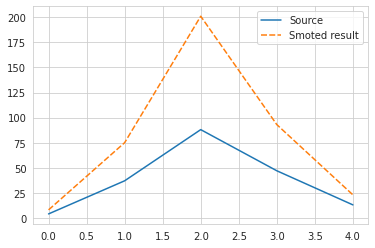

In [12]:
test_sample_pt = np.array([i[0] for i in cts.slices[0][0][0]])
test_sample_pt_smote = np.array([i[0] for i in np.array(smote(cts.slices[0], 400)[0][0])])

assert min(test_sample_pt) == min(test_sample_pt_smote)
assert max(test_sample_pt) == max(test_sample_pt_smote)

bc_spt = np.bincount(test_sample_pt + 128)[-5:]
bc_spt_s = np.bincount(test_sample_pt_smote)[-5:]

sns.lineplot(data=pd.DataFrame(zip(bc_spt, bc_spt_s), columns=["Source", "Smoted result"]))

In [13]:
trc = np.array([round(np.random.uniform(0, 255)) for _ in range(100000)])
trc_mv = ctable_mv(np.bincount(trc, minlength=256), len(trc))

# Compare with actual mean and variance
assert_almost_equal(trc_mv, (trc.mean(), trc.var()))

[Text(0.5, 1.0, 'Mean and variance of first key, category and slice.\n')]

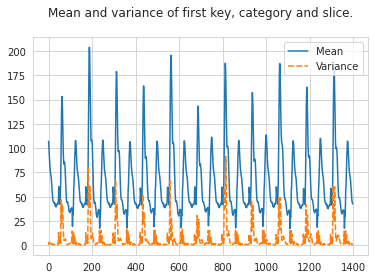

In [14]:
g = sns.lineplot(data=pd.DataFrame(mv_default[0][0][0], columns=["Mean", "Variance"]))
g.set(title="Mean and variance of first key, category and slice.\n")

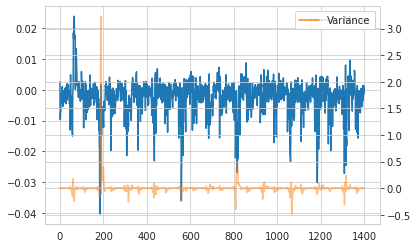

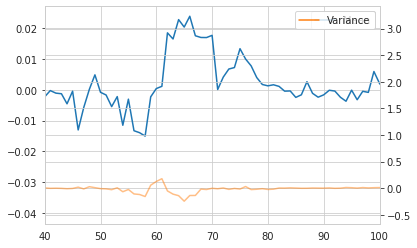

In [15]:
def make_left_right(stat_moments):
    def get_left(k):
        return stat_moments[k][1][0]

    def get_right(k):
        return stat_moments[k][1][1]

    return get_left, get_right

def get_diff(stat_moments, key_range=range(256)):
    left, right = make_left_right(stat_moments)

    kr = key_range

    dist_neq = [abs(left(i) - right(j)) for i in kr for j in kr if i != j]
    dist_eq = [abs(left(i) - right(i)) for i in kr]

    return np.mean(dist_neq, axis=0) - np.mean(dist_eq, axis=0)

mv_diff = dict(zip(["Mean", "Variance"], np.moveaxis(get_diff(mv_default), 0, -1)))
shadow_plot(mv_diff, split_y=True)
shadow_plot(mv_diff, split_y=True, xlim=(40, 100))

In [16]:
def get_num_moments(stat_moments):
    return len(stat_moments[0][0][0][0])

def get_heatmap(stat_moments):
    num_moments = get_num_moments(stat_moments)
    num_keys = len(stat_moments)

    res = np.zeros((num_keys, num_keys, num_moments), dtype=np.float128)
    for i in tqdm(range(num_keys)):
        for j in range(num_keys):
            if i == j:
                res[i][j] = np.array([0] * num_moments)
            else:
                diff = get_diff(mv_default, [i, j])
                diff[np.less(diff, 0)] = 0
                # Difference ratio over the rest of the trace
                res[i][j] = diff[50:70].sum(axis=0) / diff.sum(axis=0)

    return res

heat = get_heatmap(mv_default)

100%|██████████| 256/256 [00:13<00:00, 19.59it/s]


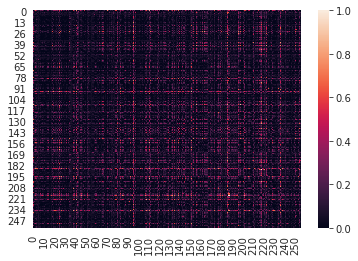

In [17]:
def get_heat_moment(heatmap, moment):
    return np.moveaxis(heatmap, 2, 0)[moment]

def plot_heatmap(heatmap):
    mean = get_heat_moment(heatmap, 0)
    mean_norm = mean / mean.max()
    sns.heatmap(data=mean_norm)

plot_heatmap(heat)

In [18]:
def get_max_index(heatmap, moment=0):
    heat_moment = get_heat_moment(heatmap, moment)
    return np.unravel_index(heat_moment.argmax(), heat_moment.shape)

get_max_index(heat)

(187, 218)

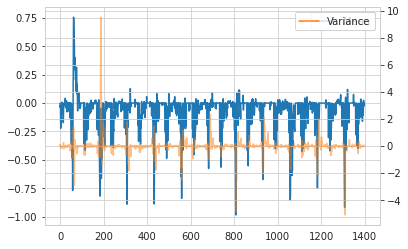

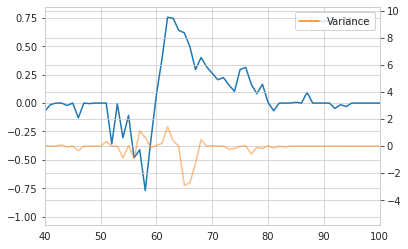

In [19]:
key_selected = get_max_index(heat)
mv_diff = dict(zip(["Mean", "Variance"], np.moveaxis(get_diff(mv_default, key_selected), 0, -1)))
shadow_plot(mv_diff, split_y=True)
shadow_plot(mv_diff, split_y=True, xlim=(40, 100))

In [33]:
def t_test_prep(left_moments, right_moments, num_samples):
    num = left_moments[0] - right_moments[0]
    den = ((left_moments[1] + right_moments[1]) / num_samples) ** .5

    return np.array(num / den)

tmp_ts = gen_trace(), gen_trace()

assert_almost_equal(t_test(*tmp_ts), t_test_prep(*[(t.mean(axis=0), t.var(axis=0)) for t in tmp_ts], len(tmp_ts[0])))

In [40]:
def tvla_prep(mvs, key_left, key_right, num_obs, poi=(None, None)):
    mvs_left, mvs_right = mvs[key_left], mvs[key_right]

    def at_poi(t):
        return t[poi[0]:poi[1]]

    a, b, c, d = np.moveaxis(mvs_left[0], 2, 1)
    x, y = np.moveaxis(mvs_right[1], 2, 1)

    tk1 = abs(np.array(t_test_prep(a, c, num_obs)))
    tk2 = abs(np.array(t_test_prep(b, d, num_obs)))
    tm1 = abs(np.array(t_test_prep(a, x, num_obs)))
    tm2 = abs(np.array(t_test_prep(b, y, num_obs)))

    confidence = np.percentile(np.array([*tk1, *tk2, *tm1, *tm2]).flatten(), 95)

    fail_eq = device_fails(at_poi(tk1), at_poi(tk2), confidence)
    fail_diff = device_fails(at_poi(tm1), at_poi(tm2), confidence)

    return fail_eq, fail_diff, np.round(confidence, 3)

tvla_prep(mv_default, *get_max_index(heat), obs_default, (50, 65))

(True, False, 2.948)

In [22]:
gen_trace().shape

(350, 50)

In [23]:
def plot_longform(traces):
    sns.set_style('whitegrid')

    longform = []
    for trace in traces:
        for ix in range(len(trace)):
            longform.append((ix, trace[ix]))

    cols = ["Sample point", "Power"]
    df = pd.DataFrame(longform, columns=cols)
    sns.lineplot(data=df, x=cols[0], y=cols[1])

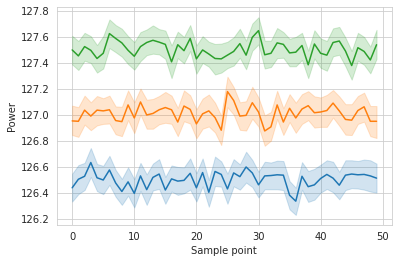

In [24]:
plot_longform(gen_trace(0))
plot_longform(gen_mask_trace())
plot_longform(gen_trace(256))